# The University of Hong Kong
## DASC7600 Data Science Project 2024
## Time Series Regression Model

# Import Modules and Settings

In [1]:
import graphviz
import os
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from statsmodels.tsa.vector_ar.var_model import VAR

import covid_module

# Settings
warnings.filterwarnings('ignore')

os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin" # To fix a graphviz bug

# Functions

In [2]:
def add_lag_columns(df: pd.DataFrame,
                       col: str,
                       lag_nbr: int) -> pd.DataFrame:
    for nbr in range(1, lag_nbr+1):
        df[f'{col}_lag{nbr}'] = df[col].shift(nbr)
    return df

# Load Data

In [3]:
# Read csv files
covid_hk_std = pd.read_csv('./data/std_data/hk/covid_hk_case_std.csv')
hk_daily_temp_std = pd.read_csv('./data/std_data/hk/hk_daily_temp_std.csv')

# Modify Data Type

In [4]:
covid_hk_std['report_date'] = pd.to_datetime(covid_hk_std['report_date'], format='%Y%m%d')
hk_daily_temp_std['report_date'] = pd.to_datetime(hk_daily_temp_std['report_date'], format='%Y%m%d')

# New Case Counts

In [5]:
covid_hk_new_case_cnt_df = covid_module.get_date_count(covid_hk_std, 'report_date', '%Y%m%d')

# Combine Case Count and Temperature

In [6]:
covid_hk_case_cnt_temp = covid_hk_new_case_cnt_df \
    .merge(hk_daily_temp_std,
           'left',
           'report_date')

# Train Model

## Regression Tree Model

### Add Lag Columns for Regression Tree Model

In [7]:
# Lagged number
lag_nbr = 7

covid_hk_case_cnt_temp_lag = covid_hk_case_cnt_temp.copy()
for col in ['count', 'avg_temp']:
    add_lag_columns(covid_hk_case_cnt_temp_lag, col, lag_nbr)

# Drop first 7 rows
# They have missing values due to the lagging
covid_hk_case_cnt_temp_lag = covid_hk_case_cnt_temp_lag.iloc[7:]

In [8]:
# To confirm there is no missing values due to join or lagging
covid_module.print_missing_val_count(covid_hk_case_cnt_temp_lag)

The dataframe does not have missing values.


### Training Data and Test Data for Tree Model

In [9]:
tree_X_col_list = [col for col in covid_hk_case_cnt_temp_lag.columns if ('count_lag' in col) or ('avg_temp' in col)]

tree_X = covid_hk_case_cnt_temp_lag[tree_X_col_list]
tree_y = covid_hk_case_cnt_temp_lag['count']

# Split into train set and test set with ratio 0.8 : 0.2
tree_X_train, tree_X_test, tree_y_train, tree_y_test = train_test_split(tree_X, tree_y, test_size=0.2, random_state=2024)

### Fit Regression Tree Model

In [20]:
# Regression Tree model
reg_tree_model = DecisionTreeRegressor(min_samples_leaf=5, max_depth=3, random_state=2024)

# Fit the Regression Tree model
reg_tree_model.fit(tree_X_train, tree_y_train)

print(f"Test score of Regression Tree Model is {reg_tree_model.score(tree_X_test, tree_y_test): .4f}.")

Test score of Regression Tree Model is  0.7712.


### Graph and Feature Importance of the Tree Model

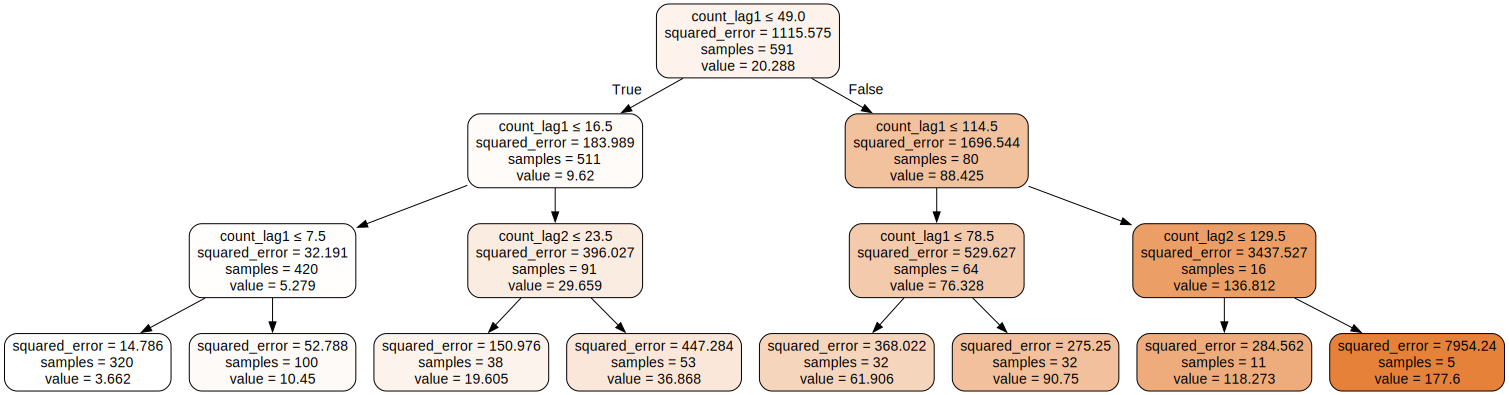

In [21]:
# Export a decision tree in DOT format with Graphviz
dot_graph = export_graphviz(reg_tree_model,
                            feature_names=reg_tree_model.feature_names_in_,
                            filled=True,
                            rounded=True,
                            special_characters=True)

tree_graph = graphviz.Source(dot_graph, format="png")

# Print the structure of regression tree
tree_graph

In [22]:
# Feature importances
feature_importance_df = pd.DataFrame({'Variable Name': reg_tree_model.feature_names_in_, 'Importance': reg_tree_model.feature_importances_})

feature_importance_df.sort_values(by='Importance', ascending=False)

,Variable Name,Importance
1,count_lag1,0.966399
2,count_lag2,0.033601
0,avg_temp,0.000000
3,count_lag3,0.000000
4,count_lag4,0.000000
5,count_lag5,0.000000
6,count_lag6,0.000000
7,count_lag7,0.000000
8,avg_temp_lag1,0.000000
9,avg_temp_lag2,0.000000


## Vector Autoregressions (VAR) Model

###  Data for VAR Model

In [13]:
var_data = covid_hk_case_cnt_temp[['report_date', 'count', 'avg_temp']]

var_data.set_index('report_date', inplace=True)

### Fit VAR Model

In [26]:
# VAR model
var_model = VAR(var_data)

# Select lag order based on AIC
var_lag_order = var_model.select_order().aic

# Fit the VAR model
var_model = var_model.fit(maxlags=var_lag_order)

# Summary of the fitted VAR model
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 10, Aug, 2024
Time:                     22:58:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.96085
Nobs:                     731.000    HQIC:                   5.72150
Log likelihood:          -4048.75    FPE:                    262.768
AIC:                      5.57117    Det(Omega_mle):         241.823
--------------------------------------------------------------------
Results for equation count
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                5.317364         2.743922            1.938           0.053
L1.count             0.734335         0.037345           19.664           0.000
L1.avg_temp         -0.048570         0.378970           -0.128 

### Prediction of the Fitted VAR Model

In [15]:
# Predict case counts and average temperatures for the next 5 days
pd.DataFrame(var_model.forecast(var_data.values, steps=5), columns=var_data.columns)

,count,avg_temp
0,364.929408,15.011237
1,348.514670,17.170302
2,404.008979,17.937134
3,404.436782,18.254130
4,370.446990,16.407104
